In [4]:
using PyPlot

In [5]:
# discretization
t = Array(2020:1.:2100);

# CO2 concentration (ppm) at t[1]
c_00 = 415.;

# physical climate parameters
ECS = 3.; # Equilibrium Climate Sensitivity
ϵ = ECS/log(2.); # Transient Warming Parameter
δT_00 = 1.1; # Warming at t[1] since preindustrial

# baseline emissions scenarios
q = 5. .* ones(size(t)); # emissions scenario
q[40:81] .= q[1] * (40. .-(0.:1.:41.))/40.
q[81:end] .= 0.
c_0 = c_00 .+ cumsum(q); # cumulative CO2 concentrations (ppm)
δT_0 = δT_00 .+ ϵ.*log.(c_0/c_00); # warming due to baseline emissions scenario

# economic parameters
β = 1.; # damage parameter (trillion dolars / C^2)
D_0 = β .* δT_0.^2; # baseline damages
γ = 0. #1. /30. # discount rate
ρ = 0.03
GWP = 100. # Global World Product (10^12 $/yr)
C_ϕ = 0.05*GWP; # carbon removal (10^12 $/yr)
C_φ = 0.05*GWP; # emissions reductions (10^12 $/yr)
C_χ = 0.1*GWP; # adaptation (10^12 $/yr)
C_λ = 0.2*GWP; # geoengineering (10^12 $/yr)

f_low(α::Array) = (α ./ (1. .+ α)).^2 # shape of individual cost functions
f_med(α::Array) = α.^2 # shape of individual cost functions
f_high(α::Array) = (α ./ (1. .- α)).^2 # shape of individual cost functions

# Example control trajectories
# (picked because cost of controls + cost of controlled damage < uncontrolled damage)
nondim_linear(t::Array) = (t .- t[1])/(t[end] - t[1]);
ϕ = nondim_linear(t);
φ = nondim_linear(t)/3.;
λ = nondim_linear(t)/10.;
χ = nondim_linear(t)/10.;

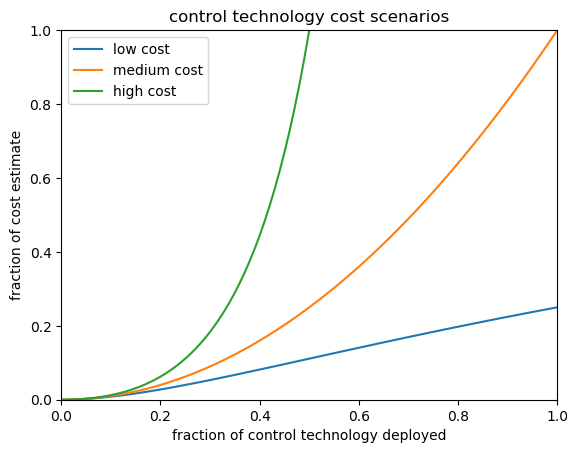

PyObject <matplotlib.legend.Legend object at 0x146cde080>

In [6]:
x = 0:0.01:1.

y_low = (x./(1. .+x)).^2
y_med = x.^2
y_high = (x./(1. .-x)).^2
title("control technology cost scenarios")
plot(x,y_low, label="low cost")
plot(x,y_med, label="medium cost")
plot(x,y_high, label="high cost")
xlim([0,1])
ylim([0,1])
ylabel("fraction of cost estimate")
xlabel("fraction of control technology deployed")
legend()

In [7]:
c(ϕ::Array, φ::Array) = c_0 .- cumsum(q .* φ) .- cumsum(q[1] .* ϕ);
δT(ϕ::Array, φ::Array) = δT_00 .+ ϵ.*log.(c(ϕ,φ)./c_00);

D(ϕ::Array, φ::Array, χ::Array, λ::Array) = (1. .- χ) .* β .* δT(ϕ, φ).^2 .* (1. .- λ).^2;

C(ϕ::Array, φ::Array, χ::Array, λ::Array) = C_λ.*f_high(λ) .+ C_ϕ.*f_med(ϕ) .+ C_φ.*f_low(φ) .+ C_χ.*f_med(χ);
T(ϕ::Array, φ::Array, χ::Array, λ::Array) = (
    sum((C(ϕ, φ, χ, λ) .+ D(ϕ, φ, χ, λ)) .* (1. / (1. + ρ)).^(t.-t[1])) .+
    200. * (sum(diff(ϕ).^2) .+ sum(diff(φ).^2) .+ sum(diff(χ).^2) .+ sum(diff(λ).^2)) .+
    200. .* (ϕ[1].^2 .+ φ[1].^2 .+ χ[1].^2 .+ λ[1].^2)
);

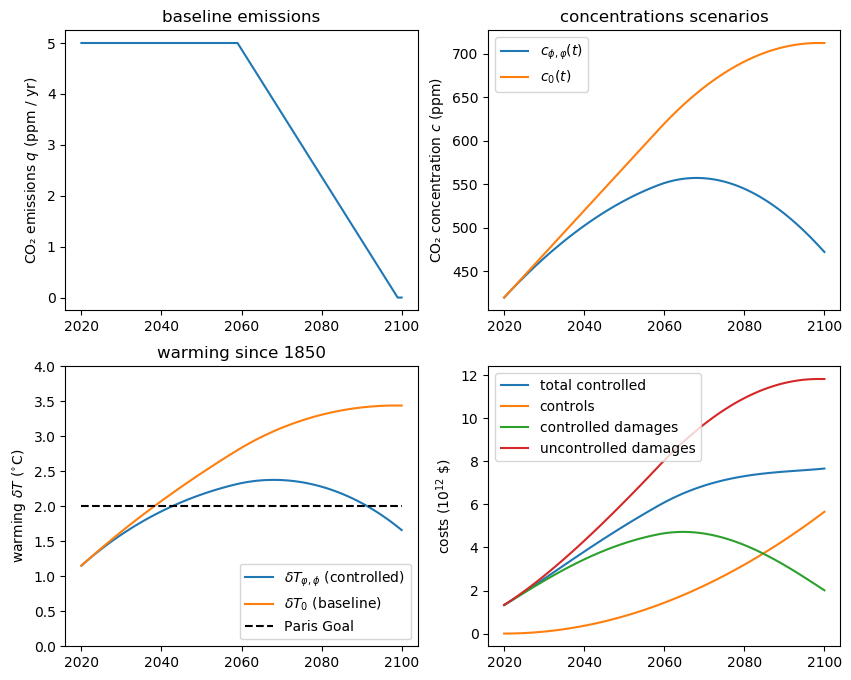

PyObject <matplotlib.legend.Legend object at 0x147454278>

In [8]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t,q)
ylabel(L"CO₂ emissions $q$ (ppm / yr)")
title("baseline emissions")

subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
title("concentrations scenarios")

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
ylim([0,4.0])
legend()
title("warming since 1850")

subplot(2,2,4)
plot(t, C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ), label="total controlled")
plot(t, C(ϕ, φ, χ, λ), label="controls")
plot(t, D(ϕ, φ, χ, λ), label="controlled damages")
plot(t, D_0, label="uncontrolled damages")
ylabel(L"costs (10$^{12}$ \$)")
legend()

## Gradient descent cost minimization

In [9]:
function ∇T(ϕ::Array, φ::Array, χ::Array, λ::Array)
    Δα = 1.e-5
    ∂T∂ϕ = zeros(size(ϕ))
    ∂T∂φ = zeros(size(φ))
    ∂T∂χ = zeros(size(χ))
    ∂T∂λ = zeros(size(λ))
    for i=1:length(ϕ)
        δα = zeros(size(ϕ))
        δα[i] = Δα
        ∂T∂ϕ[i] = (T(ϕ.+δα,φ,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂φ[i] = (T(ϕ,φ.+δα,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂χ[i] = (T(ϕ,φ,χ.+δα,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂λ[i] = (T(ϕ,φ,χ,λ.+δα) .- T(ϕ,φ,χ,λ))/Δα
    end
    
    return (∂T∂ϕ, ∂T∂φ, ∂T∂χ, ∂T∂λ)
end

function convergence(∇T, tol = 1.e-6)
    norm = 0.
    for ∂T∂α = ∇T
        norm += sum(∂T∂α.^2)
    end
    return norm < tol
end

convergence (generic function with 2 methods)

In [10]:
count = 1
while convergence(∇T(ϕ, φ, χ, λ), 1.e-8) == false
    ∇ = ∇T(ϕ, φ, χ, λ)
    norm = 0.
    for ∂T∂α = ∇
        norm += sum(∂T∂α.^2)
    end
    print(norm, " ")
    Δs = 5.e-4
    ϕ .-= ∇[1].*Δs
    φ .-= ∇[2].*Δs
    χ .-= ∇[3].*Δs
    λ .-= ∇[4].*Δs
    count+=1
    
    if count>1000
        break
    end
end

1126.6418328683244 1034.9026057572632 979.8827876684504 937.2017081931859 900.6314689567615 867.8629922396767 837.8025214074358 809.8416977836087 783.6023366031726 758.8294287095567 735.3400320589136 712.9964021871791 691.690700339308 671.3358033093294 651.8594705394269 633.2004962907089 615.3060757985218 598.1299691365175 581.6311543612603 565.7728453262262 550.5217486005042 535.8474922601397 521.7221836634781 508.12005390548904 495.01717942909477 482.39125305546884 470.2213970368643 458.48800409887957 447.1726084504552 436.25778082056917 425.72702836107186 415.5647194725785 405.7560105701972 396.28678804725075 387.1436099065738 378.31366636961195 369.78473362860507 361.5451380603401 353.5837206759029 345.8898080980525 338.45318518137447 331.2640705297206 324.3130936123821 317.5912719424931 311.08999140700234 304.8009935347513 298.7163491012213 292.8284519863934 287.1300003594245 281.61398050529493 276.2736584691031 271.10256592734646 266.0944893916087 261.2434573724767 256.5437331991

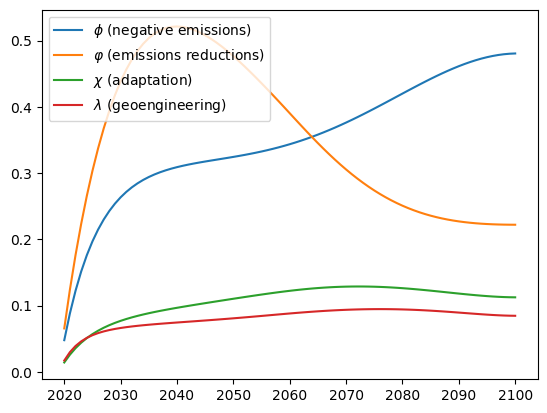

PyObject <matplotlib.legend.Legend object at 0x148101160>

In [13]:
plot(t, ϕ, label=L"$\phi$ (negative emissions)")
plot(t, φ, label=L"$\varphi$ (emissions reductions)")
plot(t, χ, label=L"$\chi$ (adaptation)")
plot(t, λ, label=L"$\lambda$ (geoengineering)")
legend()

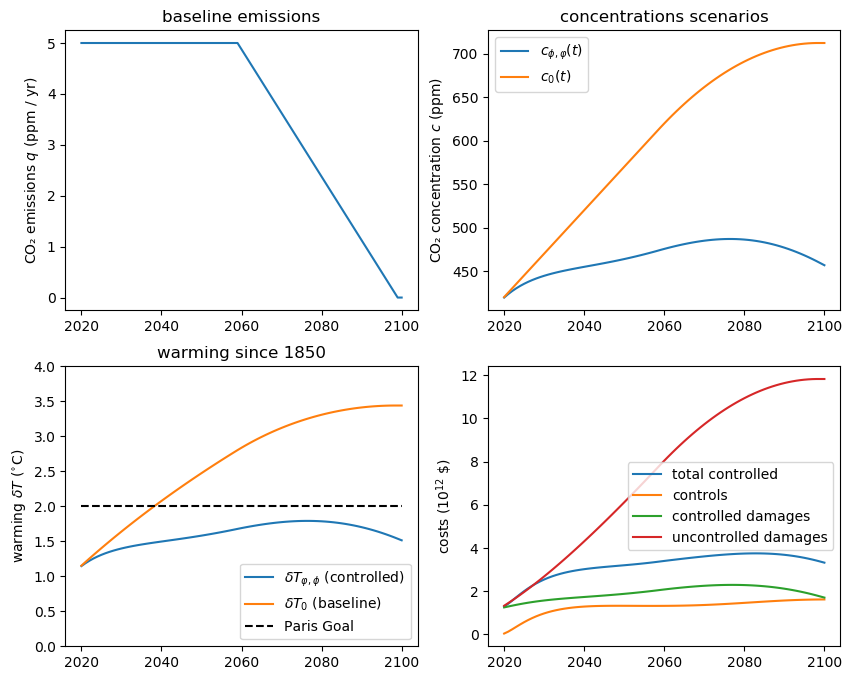

PyObject <matplotlib.legend.Legend object at 0x148553dd8>

In [14]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t,q)
ylabel(L"CO₂ emissions $q$ (ppm / yr)")
title("baseline emissions")

subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
title("concentrations scenarios")

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
ylim([0,4.0])
legend()
title("warming since 1850")

subplot(2,2,4)
plot(t, C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ), label="total controlled")
plot(t, C(ϕ, φ, χ, λ), label="controls")
plot(t, D(ϕ, φ, χ, λ), label="controlled damages")
plot(t, D_0, label="uncontrolled damages")
ylabel(L"costs (10$^{12}$ \$)")
legend()